The idea of this analysis is to use NHL player and team performance data to determine the characteristics of a high-performing NHL team, i.e., what kind of players do they have? With a model like this, we can look at the roster of a team, and determine their chances of going deep into the playoffs, and we can also make suggestions about what kinds of player moves they must make in order to become a great team.

I decided to use regular season player statistics, because this ensures we have a lot of data on every player in the league. However, to determine if a team is a high-performer, I used playoff performance, not regular season performance. It might be worth trying to use regular season data, but playoff performance is the ultimate test, and arguably the nature of the game changes in the playoffs. 

My approach was as follows:
1. Use clustering to group similar players. I used three different segments of players--forwards, defenders, and goalies, and created clusters in each
2. Use those clusters to characterize the 32 NHL teams for various seasons between 2008/9 and 2021/22. How many players from each cluster do the teams have? 
3. Then use logistic regression to see if we can find relationships between teams having certain mixes of players, and going "deep" in the playoffs. e.g., What's the relationship between having a forward from cluster 3 and going deep in the playoffs? If we know that, we know how important it is to have such players on your roster.

First, we'll do some imports and read the various files that we need. Moneypuck.com has some good data with a lot of metrics on skaters (defenders and forwards). The skaters have 154 different columns. It's difficult to know which ones matter, so at this stage we'll use them all. Moneypuck.com also has similar data on goalies (although goalie metrics are completely different from those of skaters). There are 36 different fields in the goalie metrics files. We'll read in all the data for skaters and goalies between 2008/9-2021/22. Then we'll scale them so that the magnitudes of the various metrics don't cause any distortions, and so that we can see the relative importance of various variables.  

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt
#from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

np.random.seed(97)

GOALIES_DATA_PATH = '../input/nhl-player-and-team-data-20089202122/regular/goalies/'
SKATERS_DATA_PATH = '../input/nhl-player-and-team-data-20089202122/regular/skaters/'
TEAMS_DATA_PATH = '../input/nhl-player-and-team-data-20089202122/playoffs/teams/'

NUM_CLUST_FORWARDS = 11
NUM_CLUST_DEFENSE = 9
NUM_CLUST_GOALIES = 5

TEAM_MAPPING = dict({
                     'Colorado Avalanche':'COL',
                     'Tampa Bay Lightning':'TBL',
                     'New York Rangers':'NYR',
                     'Edmonton Oilers':'EDM',
                     'Carolina Hurricanes':'CAR',
                     'St. Louis Blues':'STL',
                     'Calgary Flames':'CGY',
                     'Florida Panthers':'FLA',
                     'Boston Bruins':'BOS',
                     'Los Angeles Kings':'LAK',
                     'Toronto Maple Leafs':'TOR',
                     'Dallas Stars':'DAL',
                     'Pittsburgh Penguins':'PIT',
                     'Minnesota Wild':'MIN',
                     'Washington Capitals':'WSH',
                     'Nashville Predators':'NSH',
                     'Detroit Red Wings':'DET',
                     'Philadelphia Flyers':'PHI',
                     'San Jose Sharks':'SJS',
                     'Montreal Canadiens':'MTL',
                     'New Jersey Devils':'NJD',
                     'Ottawa Senators':'OTT',
                     'Anaheim Ducks':'ANA',
                     'Winnipeg Jets':'WPG',
                     'Chicago Blackhawks':'CHI',
                     'Vegas Golden Knights':'VGK',
                     'New York Islanders':'NYI',
                     'Vancouver Canucks':'VAN',
                     'Arizona Coyotes':'ARI',
                     'Phoenix Coyotes':'ARI',
                     'Columbus Blue Jackets':'CBJ',
                     'Buffalo Sabres':'BUF'
                     })

PLAYER_TEAM_MAPPING = dict({
                     'T.B':'TBL',
                     'S.J':'SJS',
                     'N.J':'NJD',
                     'L.A':'LAK'
                     })

YEARS_LIST = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

dir_list = os.listdir(SKATERS_DATA_PATH) 

li = []

for f in dir_list:
    df = pd.read_csv(SKATERS_DATA_PATH + f)
    li.append(df) 

players_df = pd.concat(li, axis=0, ignore_index=True)    

players_df = players_df[players_df['situation']=='all']
players_df['team'] = players_df['team'].replace(PLAYER_TEAM_MAPPING)

#players_df.drop(players_df[(players_df['games_played'] < 20)].index,inplace=True)

defense_df = players_df[players_df['position']=='D']
defense_df.reset_index
print('Shape of the defense dataframe: ',defense_df.shape)

forwards_df = players_df.loc[(players_df['position'] == 'L') | (players_df['position']=='C') | (players_df['position']=='R') ]
forwards_df.reset_index
print('Shape of the forwards dataframe: ',forwards_df.shape)

dir_list = os.listdir(GOALIES_DATA_PATH) 

li = []

for f in dir_list:
    df = pd.read_csv(GOALIES_DATA_PATH + f)
    li.append(df) 
    
goalies_df = pd.concat(li, axis=0, ignore_index=True)   
goalies_df = goalies_df[goalies_df['situation']=='all']

#goalies_df.drop(goalies_df[(goalies_df['games_played'] < 10)].index,inplace=True)
goalies_df.reset_index
print('Shape of the goalies dataframe: ',goalies_df.shape)

dir_list = os.listdir(TEAMS_DATA_PATH) 

li = []

for f in dir_list:
    df = pd.read_csv(TEAMS_DATA_PATH + f)
    li.append(df) 
    
teams_df = pd.concat(li, axis=0, ignore_index=True)  
teams_df.reset_index 

# Replace team names with 3 letter code
teams_df['Team'] = teams_df['Team'].replace(TEAM_MAPPING)

print('Shape of the teams dataframe: ',teams_df.shape)
   
scaler = MinMaxScaler()

players_cols = list(players_df.columns)
non_feature_cols = ['playerId','season','name','team','position','situation']
players_features = [x for x in players_cols if x not in non_feature_cols]

goalies_cols = list(goalies_df.columns)
non_feature_cols = ['playerId','season','name','team','position','situation']
goalies_features = [x for x in goalies_cols if x not in non_feature_cols]

defense_scaled=scaler.fit_transform(defense_df[players_features])
#print(defense_scaled)
forwards_scaled=scaler.fit_transform(forwards_df[players_features])
#print(forwards_scaled)
goalies_scaled=scaler.fit_transform(goalies_df[goalies_features])

Shape of the defense dataframe:  (4303, 154)
Shape of the forwards dataframe:  (8233, 154)
Shape of the goalies dataframe:  (1296, 36)
Shape of the teams dataframe:  (232, 13)


Now let's cluster the defenders using k-means. K-means is a fairly simple unsupervised ML model. We'll plot an "elbow" plot to see how many clusters we should use. As you can see, there's an asymptote at about 6-7 clusters, so there's not much point in using more than that. 

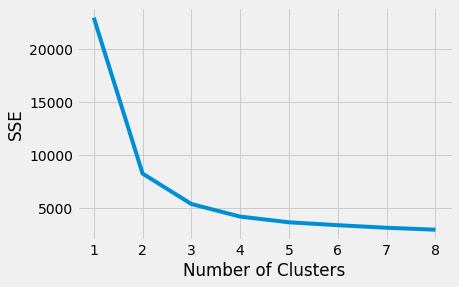

In [2]:
kmeans_kwargs = {
                "init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42,
                }

# A list holds the SSE values for each k
clusters=NUM_CLUST_DEFENSE
sse = []
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(defense_scaled)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, clusters), sse)
plt.xticks(range(1, clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

We'll assign the defenders (by season), over the years, to clusters. Then we'll make a decision on how to give each player a single overall cluster assignment, over ALL the years. We'll do that with the mode (the most common cluster assignment) for a player across all years. i.e., so if a player appears in 3 seasons, and is in cluster 2 in two seasons and cluster 3 in one season, we'll say they are a cluster 2 player, on the whole.

At this stage, we don't really know what the clusters mean. We just know that k-means thinks the players are grouped together, based on their statistics. 

In [3]:
defense_cluster_assignments = kmeans.labels_ 
defense_df.insert(loc=0, column='cluster', value=defense_cluster_assignments)

defense_list = defense_df['name'].unique()
defense_clusters = {}
for f in defense_list:
    m = defense_df.loc[defense_df['name']==f].cluster.mode()[0]
    defense_clusters[f] = m
    
list(defense_clusters.items())[0:10]

[('Blake Hillman', 0),
 ('Victor Mete', 4),
 ('Alexander Edler', 5),
 ('Kyle Quincey', 1),
 ('Jaycob Megna', 0),
 ('Mike Reilly', 1),
 ('Robert Bortuzzo', 6),
 ('Shea Weber', 3),
 ('Marcus Pettersson', 1),
 ('Ben Lovejoy', 1)]

Now let's do the same for forwards. It looks like using much more than 8-9 clusters isn't useful. 

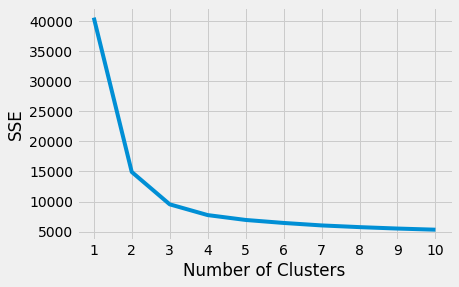

[('Justin Auger', 1),
 ('Frans Nielsen', 8),
 ('Martin Hanzal', 0),
 ('Michael Dal Colle', 1),
 ('Kyle Palmieri', 0),
 ('Dmitrij Jaskin', 1),
 ('Marcus Sorensen', 9),
 ('Jannik Hansen', 6),
 ('Max Pacioretty', 2),
 ('Mark Jankowski', 4)]

In [4]:
kmeans_kwargs = {
                "init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42,
                }

# A list holds the SSE values for each k
clusters=NUM_CLUST_FORWARDS
sse = []
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(forwards_scaled)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, clusters), sse)
plt.xticks(range(1, clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

forwards_cluster_assignments = kmeans.labels_ 
forwards_df.insert(loc=0, column='cluster', value=forwards_cluster_assignments)

forwards_list = forwards_df['name'].unique()
forwards_clusters = {}
for f in forwards_list:
    m = forwards_df.loc[forwards_df['name']==f].cluster.mode()[0]
    forwards_clusters[f] = m
    
list(forwards_clusters.items())[0:10]

And now for goalies.

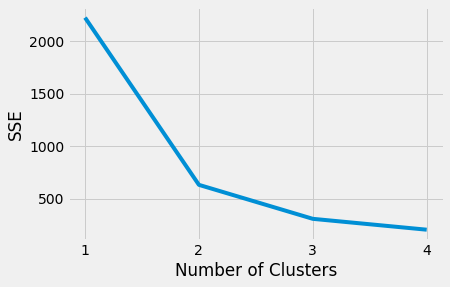

[('Kari Lehtonen', 2),
 ('Curtis McElhinney', 0),
 ('Jack Campbell', 3),
 ('Jared Coreau', 0),
 ('Antoine Bibeau', 3),
 ('Al Montoya', 0),
 ('Robin Lehner', 0),
 ('Charlie Lindgren', 3),
 ('Anders Nilsson', 0),
 ('Connor Hellebuyck', 2)]

In [5]:
kmeans_kwargs = {
                "init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42,
                }

# A list holds the SSE values for each k
clusters=NUM_CLUST_GOALIES
sse = []
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(goalies_scaled)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, clusters), sse)
plt.xticks(range(1, clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

goalies_cluster_assignments = kmeans.labels_ 
goalies_df.insert(loc=0, column='cluster', value=goalies_cluster_assignments)

goalies_list = goalies_df['name'].unique()
goalies_clusters = {}
for f in goalies_list:
    mode = goalies_df.loc[goalies_df['name']==f].cluster.mode()[0]
    goalies_clusters[f] = mode

list(goalies_clusters.items())[0:10]

So we've grouped all of the forwards, defenders, and goalies into a handful of clusters. But what do these clusters mean? Are they useful?

Let's start out by looking at the forwards. We can use Principal Components Analysis (PCA) to distill the many metrics that we have for skaters into a much smaller number of dimensions. I'll just use two dimensions because I want to plot them.

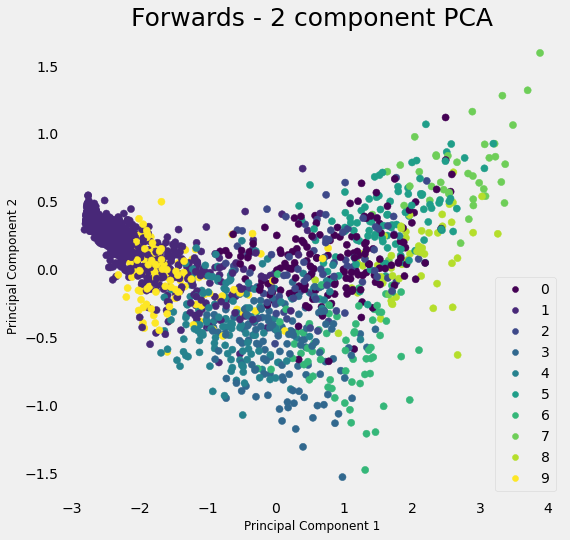

In [6]:
# forwards PCA with 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(forwards_scaled)
pca_forwards_by_season = pd.DataFrame(data = PC, columns = ['PC1', 'PC2'])
pca_forwards_by_season.insert(loc=0, column='cluster', value=forwards_cluster_assignments)
pca_forwards_by_season.insert(loc=1, column='name', value=forwards_df['name'].to_list())
pca_forwards_by_season.insert(loc=1, column='season', value=forwards_df['season'].to_list())
pca_forwards_by_season.insert(loc=1, column='team', value=forwards_df['team'].to_list())

forwards_list = pca_forwards_by_season['name'].unique()
col = ['name', 'cluster', 'PC1', 'PC2']
forwards_clusters_pca = {}

for f in forwards_list:
    mode = pca_forwards_by_season.loc[pca_forwards_by_season['name']==f].cluster.mode()[0]
    mean1 = pca_forwards_by_season.loc[pca_forwards_by_season['name']==f].PC1.mean()
    mean2 = pca_forwards_by_season.loc[pca_forwards_by_season['name']==f].PC2.mean()
    forwards_clusters_pca[f] = (mode,mean1,mean2)
    
forwards_pca_df = pd.DataFrame.from_dict(forwards_clusters_pca,orient='index',columns=['cluster', 'PC1', 'PC2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Forwards - 2 component PCA', fontsize = 25)

scatter = ax.scatter(forwards_pca_df['PC1'],
           forwards_pca_df['PC2'],
           c = forwards_pca_df['cluster'],
           s = 50)

plt.legend(*scatter.legend_elements())
ax.grid()  

So with 10 forwards clusters, we can see that reducing the number of dimensions still left us with some reconizable clusters (remember we had assigned the players to clusters before we ran the PCA). The clusters do bleed into each other. But remember how we determined what cluster a player was in: we took the mode of a player's cluster assignment over the seasons. So while a player could have been in different clusters in different seasons, we made a decision on what cluster to assign a player to based on the mode of their performance. So while a player may have performed at a certain level in one season, on the whole their average performance may have placed them in a different cluster. 

So if we look at, say, Rick Nash over various seasons, he appeared in different clusters.

In [7]:
forwards_df[forwards_df['name']=='Rick Nash']

,cluster,playerId,season,name,team,position,situation,games_played,icetime,shifts,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
956,5,8470041,2017,Rick Nash,BOS,L,all,71,72658.0,1725.0,...,144.06,147.92,2748.0,3119.0,0.0,0.0,0.0,0.0,0.0,0.0
8081,5,8470041,2016,Rick Nash,NYR,L,all,66,65048.0,1629.0,...,130.66,125.73,2617.0,2764.0,0.0,0.0,0.0,0.0,0.0,0.0
11201,7,8470041,2010,Rick Nash,CBJ,R,all,75,85170.0,1780.0,...,110.89,130.20,2546.0,2945.0,0.0,0.0,0.0,0.0,0.0,0.0
13686,0,8470041,2015,Rick Nash,NYR,L,all,60,60982.0,1518.0,...,99.93,116.94,2198.0,2537.0,0.0,0.0,0.0,0.0,0.0,0.0
18486,2,8470041,2012,Rick Nash,NYR,R,all,44,52722.0,1098.0,...,68.92,72.96,1572.0,1746.0,0.0,0.0,0.0,0.0,0.0,0.0
25291,5,8470041,2013,Rick Nash,NYR,L,all,65,66369.0,1592.0,...,121.73,123.67,2641.0,2609.0,0.0,0.0,0.0,0.0,0.0,0.0
35801,7,8470041,2008,Rick Nash,CBJ,R,all,78,99021.0,2237.0,...,100.40,118.66,2414.0,2650.0,0.0,0.0,0.0,0.0,0.0,0.0
45441,7,8470041,2009,Rick Nash,CBJ,R,all,75,94238.0,2137.0,...,91.64,122.03,2270.0,2722.0,0.0,0.0,0.0,0.0,0.0,0.0
50696,7,8470041,2011,Rick Nash,CBJ,R,all,82,93896.0,1993.0,...,118.10,134.80,2671.0,3017.0,0.0,0.0,0.0,0.0,0.0,0.0
60271,7,8470041,2014,Rick Nash,NYR,R,all,79,82727.0,2010.0,...,144.39,145.13,2977.0,3238.0,0.0,0.0,0.0,0.0,0.0,0.0


But overall, he was found to be a cluster 7 forward because that was the most common cluster he appeared in (i.e., the mode).

In [8]:
forwards_pca_df[forwards_pca_df.index == 'Rick Nash']


,cluster,PC1,PC2
Rick Nash,7,2.541775,0.555328


OK so what do the clusters mean? It's not so clear. But let's try to find the "top" forwards cluster. Clearly Connor McDavid, Sidney Crosby and Alex Ovechkin are top tier forwards. Are they in the same cluster? Yes, they are! So that's encouraging. Even though we fed a huge number of metrics on each player, by season, into the clustering algorithm, and we frankly had little idea if many of those metrics mattered,  the algorithm determined that there was something similar about those players and they should be clustered together.

In [9]:
print(forwards_pca_df[forwards_pca_df.index == 'Sidney Crosby'])
print(forwards_pca_df[forwards_pca_df.index == 'Connor McDavid'])
print(forwards_pca_df[forwards_pca_df.index == 'Alex Ovechkin'])

               cluster       PC1       PC2
Sidney Crosby        7  2.886168  1.161218
                cluster       PC1       PC2
Connor McDavid        7  3.698124  1.318334
               cluster       PC1      PC2
Alex Ovechkin        7  3.880046  1.59344


Let's see who else is a top-tier forward. It makes sense, doesn't it? We've heard of all or most of these players. 

In [10]:
print(forwards_pca_df[forwards_pca_df['cluster'] == 7])

                    cluster       PC1       PC2
Patrick Kane              7  3.067516  0.919985
Andrew Ladd               7  1.658764  0.066016
Eric Staal                7  3.311778  0.642734
Corey Perry               7  2.287973  0.610049
Sidney Crosby             7  2.886168  1.161218
Rick Nash                 7  2.541775  0.555328
Jeff Carter               7  2.545261  0.565567
Mikko Rantanen            7  1.828281  0.767320
Jeff Skinner              7  2.465668  0.586698
Nathan MacKinnon          7  3.212951  0.924937
Nazem Kadri               7  1.418303  0.402945
Patrick Marleau           7  3.079912  0.538473
Vladimir Tarasenko        7  1.637562  0.718996
John Tavares              7  3.482668  1.062174
Phil Kessel               7  2.986808  0.636711
Mark Scheifele            7  1.884205  0.469387
Tyler Seguin              7  2.660915  0.788042
Johnny Gaudreau           7  2.357272  0.832788
Blake Wheeler             7  2.834321  0.368764
David Pastrnak            7  2.040411  0

Let's visualize the top tier forwards by plotting their two PCA components on a scatter plot.

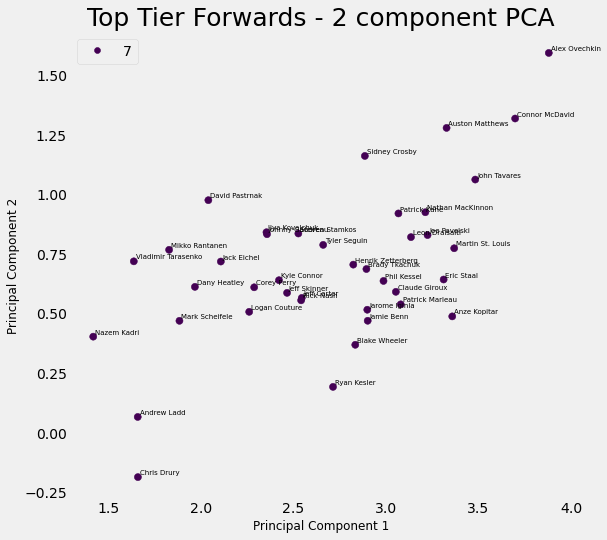

In [11]:
forwards_top_df = forwards_pca_df[forwards_pca_df['cluster']==7]
forwards_top_df.reset_index()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Top Tier Forwards - 2 component PCA', fontsize = 25)

scatter = ax.scatter(forwards_top_df['PC1'],
           forwards_top_df['PC2'],
           c = forwards_top_df['cluster'],
           s = 50)

for i, row in forwards_top_df.iterrows():
    plt.annotate(i, (forwards_top_df.loc[i]['PC1']+0.01,forwards_top_df.loc[i]['PC2']+0.01),fontsize=7)

plt.legend(*scatter.legend_elements())
ax.grid()  


Interesting! So these are the top tier forwards, based on all those metrics. Does this mean that Ovechkin is better than McDavid, because he is a bit further towards the upper right? It's debatable. The algorithm isn't really judging that. It's just distilling all those metrics down to two dimensions, and plotting the cluster 7 forwards on a 2D plot. But it's interesting nonetheless. 

Now let's run PCA on the defenders, and find the top tier defenders cluster. 

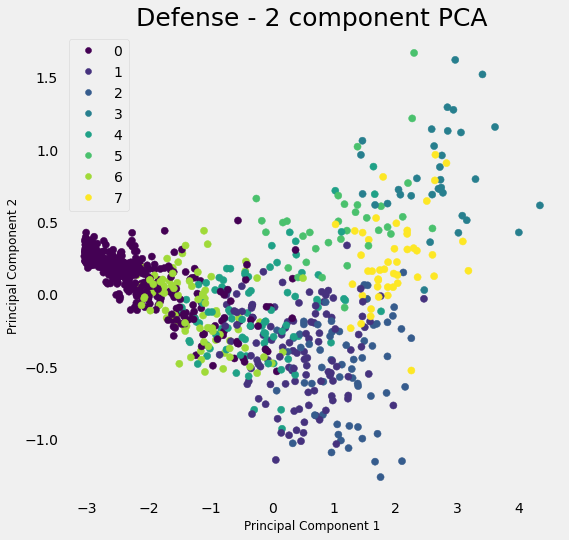

In [12]:
# Defense PCA with 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(defense_scaled)
pca_defense_by_season = pd.DataFrame(data = PC, columns = ['PC1', 'PC2'])
pca_defense_by_season.insert(loc=0, column='cluster', value=defense_cluster_assignments)
pca_defense_by_season.insert(loc=1, column='name', value=defense_df['name'].to_list())
pca_defense_by_season.insert(loc=1, column='season', value=defense_df['season'].to_list())
pca_defense_by_season.insert(loc=1, column='team', value=defense_df['team'].to_list())

defense_list = pca_defense_by_season['name'].unique()

col = ['name', 'cluster', 'PC1', 'PC2']
defense_clusters_pca = {}

for f in defense_list:
    mode = pca_defense_by_season.loc[pca_defense_by_season['name']==f].cluster.mode()[0]
    mean1 = pca_defense_by_season.loc[pca_defense_by_season['name']==f].PC1.mean()
    mean2 = pca_defense_by_season.loc[pca_defense_by_season['name']==f].PC2.mean()
    defense_clusters_pca[f] = (mode,mean1,mean2)
    
defense_pca_df = pd.DataFrame.from_dict(defense_clusters_pca,orient='index',columns=['cluster', 'PC1', 'PC2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Defense - 2 component PCA', fontsize = 25)

scatter = ax.scatter(defense_pca_df['PC1'],
           defense_pca_df['PC2'],
           c = defense_pca_df['cluster'],
           s = 50)

plt.legend(*scatter.legend_elements())
ax.grid()  


Again, we've clustered the defensemen, but what do the clusters mean? Can we find a cluster of top tier D-men? Where do Victor Hedman and a few others end up. Are they in the same cluster?

In [13]:
print(defense_pca_df[defense_pca_df.index == 'Victor Hedman'])
print(defense_pca_df[defense_pca_df.index == 'Duncan Keith'])
print(defense_pca_df[defense_pca_df.index == 'Morgan Rielly'])
print(defense_pca_df[defense_pca_df.index == 'Drew Doughty'])

               cluster       PC1       PC2
Victor Hedman        3  2.696623  0.730546
              cluster       PC1       PC2
Duncan Keith        3  3.020855  0.425776
               cluster       PC1       PC2
Morgan Rielly        3  3.083819  0.544273
              cluster      PC1       PC2
Drew Doughty        3  3.29805  0.797287


Yes! So clearly k-means has grouped these players into a top tier defenders cluster. The other clusters are probably mid-tier defenders, and bottom-tier defenders. Let's plot the top tier cluster on a 2x2 plot, using their average PCA values (across seasons).

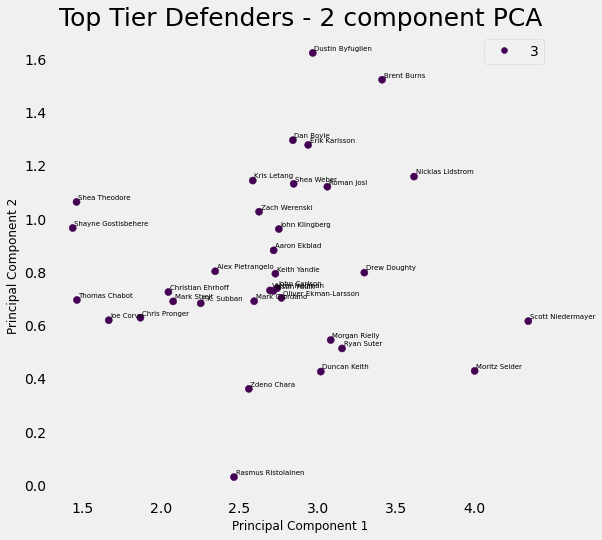

In [14]:
defense_top_df = defense_pca_df[defense_pca_df['cluster']==3]
defense_top_df.reset_index()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Top Tier Defenders - 2 component PCA', fontsize = 25)

scatter = ax.scatter(defense_top_df['PC1'],
           defense_top_df['PC2'],
           c = defense_top_df['cluster'],
           s = 50)

for i, row in defense_top_df.iterrows():
    plt.annotate(i, (defense_top_df.loc[i]['PC1']+0.01,defense_top_df.loc[i]['PC2']+0.01),fontsize=7)

plt.legend(*scatter.legend_elements())
ax.grid() 

It makes sense, doesn't it? You've heard of most of these guys. Although there are a few you might not have heard of. I hadn't heard of Moritz Seider. But it turns out he was a rookie last season and racked up a lot of assists for a bad team (Detroit). So while he has a very short track record, it looks like he probably deserves to be in the top tier cluster. 

OK let's do the same thing with goalies.

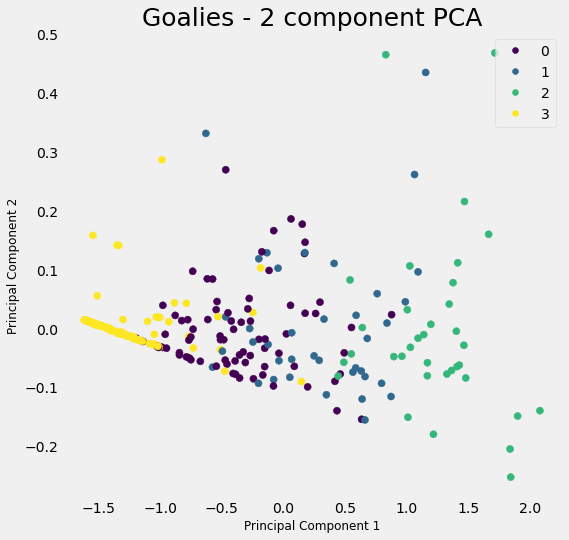

In [15]:
# Goalies PCA with 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(goalies_scaled)
pca_goalies_by_season = pd.DataFrame(data = PC, columns = ['PC1', 'PC2'])
pca_goalies_by_season.insert(loc=0, column='cluster', value=goalies_cluster_assignments)
pca_goalies_by_season.insert(loc=1, column='name', value=goalies_df['name'].to_list())
pca_goalies_by_season.insert(loc=1, column='season', value=goalies_df['season'].to_list())
pca_goalies_by_season.insert(loc=1, column='team', value=goalies_df['team'].to_list())

goalies_list = pca_goalies_by_season['name'].unique()

col = ['name', 'cluster', 'PC1', 'PC2']
goalies_clusters_pca = {}

for f in goalies_list:
    mode = pca_goalies_by_season.loc[pca_goalies_by_season['name']==f].cluster.mode()[0]
    mean1 = pca_goalies_by_season.loc[pca_goalies_by_season['name']==f].PC1.mean()
    mean2 = pca_goalies_by_season.loc[pca_goalies_by_season['name']==f].PC2.mean()
    goalies_clusters_pca[f] = (mode,mean1,mean2)
    
goalies_pca_df = pd.DataFrame.from_dict(goalies_clusters_pca,orient='index',columns=['cluster', 'PC1', 'PC2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Goalies - 2 component PCA', fontsize = 25)

scatter = ax.scatter(goalies_pca_df['PC1'],
           goalies_pca_df['PC2'],
           c = goalies_pca_df['cluster'],
           s = 50)

plt.legend(*scatter.legend_elements())
ax.grid()  
plt.show(fig)

Which is the top tier goalie cluster? This is a bit tougher because goalies seem to get hot and cold. Let's look for Vasilevskiy, Price and Lundqvist. Same cluster! So this is also making some sense.

In [16]:
print(goalies_pca_df[goalies_pca_df.index == 'Andrei Vasilevskiy'])
print(goalies_pca_df[goalies_pca_df.index == 'Carey Price'])
print(goalies_pca_df[goalies_pca_df.index == 'Henrik Lundqvist'])

                    cluster      PC1       PC2
Andrei Vasilevskiy        2  1.19699  0.007251
             cluster       PC1       PC2
Carey Price        2  1.346156  0.041617
                  cluster      PC1       PC2
Henrik Lundqvist        2  1.90148 -0.148456


Now let's plot out the top goalies cluster, cluster 2. 

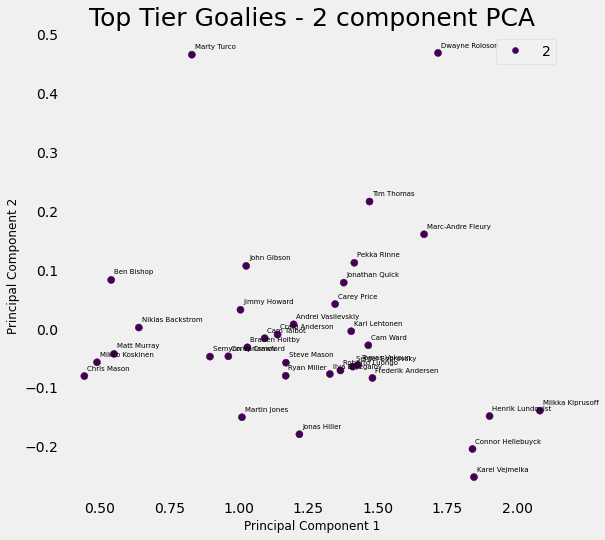

In [17]:
goalies_top_df = goalies_pca_df[goalies_pca_df['cluster']==2]
goalies_top_df.reset_index()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Top Tier Goalies - 2 component PCA', fontsize = 25)

scatter = ax.scatter(goalies_top_df['PC1'],
           goalies_top_df['PC2'],
           c = goalies_top_df['cluster'],
           s = 50)

for i, row in goalies_top_df.iterrows():
    plt.annotate(i, (goalies_top_df.loc[i]['PC1']+0.01,goalies_top_df.loc[i]['PC2']+0.01),fontsize=7)

plt.legend(*scatter.legend_elements())
ax.grid() 
plt.show(fig)

I'm not sure what Dwayne Roloson is doing in there. I didn't really consider him to be a top performer. Strangely his metrics place him in the top cluster. But it's not necessarily true that he's the best goalie in history just because he's in the upper right on the plot. We don't know that. We don't really know that that's what these PCA dimensions mean. We just know that they explain the variance among the different data points very well, and that the dimensions PCA creates are orthogonal. Further he was only in the data set for 4 seasons (he played several seasons before 2008), so the algorithm didn't know that he had some mediocre seasons prior to that. So while it looks like a bit of an outlier, it doesn't invalidate the approach. 

Let's move on an try to make some use of what we've learned. Having clustered the players, we'll try to see if there's some relationship between a team with a certain type of player (e.g., a cluster 2 forward, or a cluster 3 goalie), and the team's performance in the playoffs. 

First, let's build a dataframe, D, that contains all the teams, with rows for each season, and the types of players they had each season.  

In [18]:
# Create a dataframe of forwards, defense, goalies with their clusters
pca_forwards_by_season2 = pca_forwards_by_season
for f in forwards_list:
    clust = forwards_pca_df.loc[f].cluster
    pca_forwards_by_season2.loc[pca_forwards_by_season2['name']==f,'cluster'] = clust

pca_defense_by_season2 = pca_defense_by_season
for f in defense_list:
    clust = defense_pca_df.loc[f].cluster
    pca_defense_by_season2.loc[pca_defense_by_season2['name']==f,'cluster'] = clust

pca_goalies_by_season2 = pca_goalies_by_season
for f in goalies_list:
    clust = goalies_pca_df.loc[f].cluster
    pca_goalies_by_season2.loc[pca_goalies_by_season2['name']==f,'cluster'] = clust

teams_list = list(TEAM_MAPPING.values())
col_list = ['team','season','wins','GoingDeep']
col_list += ['F'+str(i) for i in range(NUM_CLUST_FORWARDS)]
col_list += ['D'+str(i) for i in range(NUM_CLUST_DEFENSE)]
col_list += ['G'+str(i) for i in range(NUM_CLUST_GOALIES)]
D = pd.DataFrame(columns=col_list)

for t in teams_list:
    for y in YEARS_LIST:
        w = teams_df[(teams_df['Team']==t) & (teams_df['season']==y)].W.to_list()
        if w == []:
            wins=0
        else:
            wins = w[0]
        #print(wins)
        fw = pca_forwards_by_season2[(pca_forwards_by_season2['team']==t) &
            (pca_forwards_by_season2['season']==y)] 
        de = pca_defense_by_season2[(pca_defense_by_season2['team']==t) &
            (pca_defense_by_season2['season']==y)] 
        go = pca_goalies_by_season2[(pca_goalies_by_season2['team']==t) &
            (pca_goalies_by_season2['season']==y)] 
        new_row = [t,y,wins,int(0)]
        for c in range(NUM_CLUST_FORWARDS):
            new_row.append(fw[fw['cluster']==c].shape[0])
        for c in range(NUM_CLUST_DEFENSE):
            new_row.append(de[de['cluster']==c].shape[0])
        for c in range(NUM_CLUST_GOALIES):
            new_row.append(go[go['cluster']==c].shape[0])            

        D = D.append(pd.DataFrame([new_row], columns=D.columns), ignore_index=True)

# Finally let's create a binary variable which is 1 if the team gets 4 or more wins in the playoffs
# Which means they made the quarter-finals (most years), and zero otherwise

D['GoingDeep'] = 0
D.loc[D['wins'] >= 4,'GoingDeep'] = 1

Let's see what this looks like. We have a dataframe that shows, by season, each team with their number of playoff wins, and a binary variable representing whether they "went deep" or not. Currently I have set this to 1 if the team got 4 or more wins in the playoffs. We could set this higher, but then you'll have a very unbalanced data set. e.g., we could set it to 16, which is the number of wins needed to win the cup (in a normal, non-Covid, year). But then you'll only have a few data points where GoingDeep = 1, so I think the analysis will be very fragile. 

In [19]:
D[D['team']=='TBL']


,team,season,wins,GoingDeep,F0,F1,F2,F3,F4,F5,...,D4,D5,D6,D7,D8,G0,G1,G2,G3,G4
14,TBL,2008,0,0,1,7,1,3,1,3,...,1,0,3,0,0,0,0,0,0,0
15,TBL,2009,0,0,2,5,1,1,3,2,...,0,1,3,0,0,0,0,0,0,0
16,TBL,2010,0,0,3,5,1,1,2,2,...,1,1,2,0,0,0,0,0,0,0
17,TBL,2011,11,1,0,9,2,1,3,2,...,2,1,2,0,0,0,0,0,0,0
18,TBL,2012,0,0,1,5,2,0,4,3,...,3,1,2,1,0,0,0,0,0,0
19,TBL,2013,0,0,2,4,0,1,5,5,...,2,1,1,1,0,0,0,0,0,0
20,TBL,2014,0,0,2,2,1,1,2,4,...,3,0,1,1,0,0,0,0,0,0
21,TBL,2015,14,1,2,4,1,1,1,5,...,2,0,1,1,0,0,0,0,0,0
22,TBL,2016,11,1,3,8,1,1,2,4,...,1,0,1,0,0,0,0,0,0,0
23,TBL,2017,0,0,3,2,0,1,1,5,...,1,1,1,2,0,0,0,0,0,0


Now we'll train a logistic regression model. This will let us make predictions about the probability that a team will go deep in the playoffs, based on its roster. Our y-variable is going to be GoingDeep, i.e., our binary variable that equals 1 if a team got at least a certain number of wins in the playoffs, and zero otherwise. The x-variables will be F0..F9, and D0..D8 and G0..G4. These just contain the number of players from each cluster that the team had during the season. So for example, if a team has 2 cluster 1 forwards, then F1=2.

In [20]:
# Logistic Regression with y variable = semis, i.e., did the team make the semis
model = LogisticRegression(solver='liblinear', C=10.0,random_state=97)

#I'm going to hold out the Leafs and Rangers because as the teams I follow, I want to give them special attention
D_2021_Leafs = D[(D['season'] == 2021) & (D['team'] == 'TOR')]
D.drop(D_2021_Leafs.index,inplace=True)

D_2021_NYR = D[(D['season'] == 2021) & (D['team'] == 'NYR')]
D.drop(D_2021_NYR.index,inplace=True)

y = D['GoingDeep'].astype('int')

X_train_full, X_test_full, y_train, y_test = train_test_split(D, y, test_size=0.20, random_state=1234)

X_train = X_train_full.drop(['team','season','wins','GoingDeep'],axis = 1)
X_test = X_test_full.drop(['team','season','wins','GoingDeep'],axis = 1)

model.fit(X_train, y_train)

train_pred_prob = model.predict_proba(X_train)
train_pred = model.predict(X_train)
train_score_ = model.score(X_train, y_train)
train_conf_m = confusion_matrix(y_train, train_pred)
train_report = classification_report(y_train, train_pred)

print("Training")
print("Confusion Matrix")
print(train_conf_m)
print(train_report)

model.fit(X_test, y_test)

test_pred_prob = model.predict_proba(X_test)
test_pred = model.predict(X_test)
test_score_ = model.score(X_test, y_test)
test_conf_m = confusion_matrix(y_test, test_pred)
test_report = classification_report(y_test, test_pred)

print("Testing")
print("Confusion Matrix")
print(test_conf_m)

print(test_report)

Training
Confusion Matrix
[[245  19]
 [ 56  36]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       264
           1       0.65      0.39      0.49        92

    accuracy                           0.79       356
   macro avg       0.73      0.66      0.68       356
weighted avg       0.77      0.79      0.77       356

Testing
Confusion Matrix
[[59  4]
 [10 17]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        63
           1       0.81      0.63      0.71        27

    accuracy                           0.84        90
   macro avg       0.83      0.78      0.80        90
weighted avg       0.84      0.84      0.84        90



The model does a great job of predicting whether a team will do badly, i.e., it predicts a team will not go deep (i.e., GoingDeep = 0). So if you tell me a team's roster at the start of the season, if I predict that a team won't get 4 or more playoff wins, I'll be right over 90% of the time.

My model has a tougher time when it predicts a team will go deep (get 4 or more playoff wins). But it still seems to have some predictive power. It actually does better on the test data than the training data. On the test data we predicted that on 27 occasions a team would go deep. That occurred 17 times. That's not bad, but the fact that the training performance is worse than the test performance is a bit fishy. If you really wanted to use this model you'd want to run it with a number of random seeds, and different numbers of clusters. A problem is that you really can't go out and get more data in this situation. We have all there is. 

At the start of the analysis, we held out the 2021/22 Leafs and Rangers rows from the teams data set, so that we could look at them in more detail and make some judgements about their rosters. Are they really good teams? The Leafs are perceived to be a strong team that always chokes. The Rangers went deep into the playoffs this year, and made it to the semis. But are they overrated? 

First we'll look at the Leafs 2021-22 lineup. Let's say it's the start of the 2021 season. What's their probability of winning a playoff round (i.e., getting at least 4 wins in the playoffs). Not so good (31% probability). It turns out they fell just short in 2021-22, with 3 playoff wins.

In [21]:
D_2021_Leafs = D_2021_Leafs.drop(['team','season','wins','GoingDeep'],axis = 1)
Leafs2021_prob = model.predict_proba(D_2021_Leafs)
Leafs2021_pred = model.predict(D_2021_Leafs)
#D_2021_Leafs
print(Leafs2021_prob)

[[0.69362056 0.30637944]]


What about the Rangers 2021 lineup. Let's say it's the start of the 2021-22 season. What's their chance of winning a playoff round and at least making the quarter-finals. The model says it's close to zero. But actually they had a pretty good season in 2021-22 and got 10 wins in the playoffs. So they may have overachieved this season by making the semis, and may not do that well again soon. On the other hand, Shesterkin wasn't clustered as a top tier goalie, but if he continues on the path he's been on, he will be soon. So the model might like their chances better if that happens. 

In [22]:
D_2021_NYR = D_2021_NYR.drop(['team','season','wins','GoingDeep'],axis = 1)
NYR_2021_prob = model.predict_proba(D_2021_NYR)
NYR_2021_pred = model.predict(D_2021_NYR)

print(NYR_2021_prob)

[[0.99617332 0.00382668]]


What's the profile of a typical team that goes deep in the playoffs. What kind of players do they have? Presumably, you want your team to look like that if they are going to have a chance to go deep. We can look at the teams that do well in the playoffs and find the average number of players they have in each cluster. 

In [23]:
D_winners = D[D['GoingDeep'] == 1]
D_win_avg = D_winners.drop(['team','season','wins','GoingDeep'],axis = 1)
D_win_avg.loc['mean'] = D_win_avg.mean() 
D_win_avg.loc['mean']

F0     2.369748
F1     4.915966
F2     1.109244
F3      1.92437
F4     1.394958
F5     2.504202
F6     1.319328
F7     1.168067
F8     1.327731
F9      0.87395
F10         0.0
D0     2.546218
D1     1.605042
D2     1.285714
D3      0.94958
D4     1.151261
D5     0.638655
D6     0.731092
D7     1.033613
D8          0.0
G0     0.773109
G1     0.504202
G2     0.764706
G3     0.478992
G4          0.0
Name: mean, dtype: object

Now let's compare the average playoff "winner" with the Leafs and Rangers. 

<AxesSubplot:title={'center':'Leafs vs. Mean Teams that Go Deep'}>

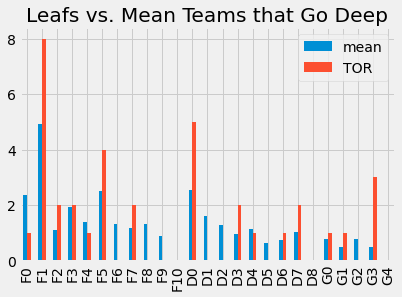

In [24]:
Bar_Comp = pd.DataFrame(D_win_avg.loc['mean'])
Bar_Comp['TOR'] = D_2021_Leafs.transpose()

Bar_Comp.plot.bar(title='Leafs vs. Mean Teams that Go Deep')

Take a look at the bar chart comparing the Leafs lineup with that of a team that wins in the playoffs. The leafs have two top tier (cluster 7) forwards: Auston Matthews and John Tavares. The typical winning team only has one. But they have more than the typical number of F1 and F5 forwards, and fewer F0, F6, F8 and F9 forwards. You'd need to dig in to understand what that means, but we can argue that the Leafs need to change their mix of non-top-tier forwards in order to win. 

On D, they match up reasonably well with the top teams, which might surprise some Leaf fans. Both Morgan Rielly and Jake Muzzin are clustered in the top tier (D7). The average winning team has just one D7 player, while the Leafs have two. But they have "too many" D0 defensemen and "not enough" D1 and D2 defensemen. 

In Goal, they had a major weak spot in 2021-22. Recall that cluster 2 is the top tier goalie cluster. In 2021-22 the Leafs didn't have a cluster 2 goalie. Most winning teams do. Previously they had Frederik Andersen, but let him get away as a free agent. My analysis shows that was an error--Andersen was a tier one goalie (cluster 2). Their starting goalie for most of the season in 2021-22 was Jack Campbell, who was not a tier one goalie according to my analysis. 

In [25]:
print(goalies_pca_df[goalies_pca_df.index == 'Frederik Andersen'])
print(goalies_pca_df[goalies_pca_df.index == 'Jack Campbell'])

                   cluster       PC1       PC2
Frederik Andersen        2  1.480373 -0.083796
               cluster       PC1       PC2
Jack Campbell        3 -0.476262 -0.072344


The potential goaltenders for the Leafs in 2022-23 are Matt Murray and Ilya Samsonov. Let's check where they clustered, compared with Jack Campbell (the 2021-22 starter). Looks like they might be an improvement.

In [26]:
print(goalies_pca_df[goalies_pca_df.index == 'Matt Murray'])
print(goalies_pca_df[goalies_pca_df.index == 'Ilya Samsonov'])
print(goalies_pca_df[goalies_pca_df.index == 'Jack Campbell'])

             cluster       PC1      PC2
Matt Murray        2  0.551359 -0.04295
               cluster       PC1      PC2
Ilya Samsonov        0  0.088501 -0.06408
               cluster       PC1       PC2
Jack Campbell        3 -0.476262 -0.072344


Murray looks interesting because he clusters as a tier one goalie, but barely, and most of this is due to his past performance for the Penguins for two Stanley Cup wins. But lately he's struggled and has done some time in the minor leagues. So if he reclaims his old form, he might be what the Leafs need to win in the playoffs, but recently he hasn't really been a tier one goalie. 

Let's look at one more thing. Note that the average playoff winner has about 1.3 cluster 8 forwards. The Leafs have zero. That looks like a problem. So what's a cluster 8 forward? I'll show you.

In [27]:
print(forwards_pca_df[forwards_pca_df.index == 'Zach Hyman'])

            cluster       PC1      PC2
Zach Hyman        8  1.853541  0.03651


Zach Hyman is a cluster 8 forward. Until this past season he was on the Leafs and was a key player for them. So there was some concern when he left the Leafs as a free agent and signed with the Oilers. Was that concern justified? Yup! And my model proves it. You want to have 1-2 players like that, and the Leafs had a very good one, and let him go. 

Now what about the Rangers 2021-22 lineup?

<AxesSubplot:title={'center':'Rangers vs. Mean for Teams that Go Deep'}>

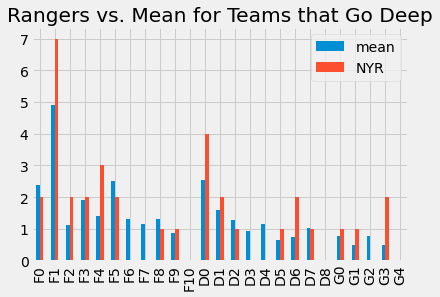

In [28]:
Bar_Comp = pd.DataFrame(D_win_avg.loc['mean'])
Bar_Comp['NYR'] = D_2021_NYR.transpose()

Bar_Comp.plot.bar(title='Rangers vs. Mean for Teams that Go Deep')

The Rangers don't have a cluster 7 forward--the top tier. That might be news to you if you are Ranger fan and think Artemi Panarin or Chris Kreider are top tier. Nope. The Rangers also lack a top tier goalie (G2), but Shesterkin is emerging as a top goalie and will probably be clustered with the top guys soon if he keeps playing well. So that problem may be solved. On D, they lack a top tier D-man. You might think Adam Fox qualifies. Nope. He's in cluster 0, which is also a very good cluster, but he's not yet in the top tier (D3). 

So this explains why the model predicted that the Rangers wouldn't go deep in the playoffs in 2021-22. That turned out to be wrong, but you might conclude they were playing over their heads based on this comparison of the Rangers lineup vs. the profile of a top team, and are unlikely to go deep next year. Or again, if Shesterkin truly emerges as a consistent top tier goalie, then maybe they'll be competitive again next year.  

In [29]:
print(goalies_pca_df[goalies_pca_df.index == 'Igor Shesterkin'])

                 cluster       PC1       PC2
Igor Shesterkin        0  0.418213 -0.089434


So what clusters matter most? In a logistic regression we need to convert the coefficients from "log odds" to "odds", as follows. Then we can compare which clusters contribute most to winning by comparing the relative magnitude of the coefficients. 

In [30]:
odds = np.exp(model.coef_[0])
pd.DataFrame(odds, 
             X_test.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
G1,2.417341
F7,2.199720
F5,1.936237
F0,1.750709
D4,1.657333
F6,1.313661
D2,1.287818
D5,1.177144
F3,1.177114
D0,1.092169


Having a top tier goalie (G2) didn't matter as might as I would have expected. Having G1 was good enough. Actually, if we look at some of the names in the G1 cluster, we have Brodeur (a Hall of Fame goalie), Niemi and Rask (both cup winners), and Nabokov, who played a lot of good years with San Jose. So clearly G1 is also a very good cluster.   

In [31]:
print(goalies_pca_df[goalies_pca_df.index == 'Mike Smith'])
print(goalies_pca_df[goalies_pca_df.index == 'Martin Brodeur'])
print(goalies_pca_df[goalies_pca_df.index == 'Tuukka Rask'])
print(goalies_pca_df[goalies_pca_df.index == 'Evgeni Nabokov'])
print(goalies_pca_df[goalies_pca_df.index == 'Antti Niemi'])

            cluster       PC1       PC2
Mike Smith        1  1.154941  0.434743
                cluster       PC1       PC2
Martin Brodeur        1  0.590207  0.022528
             cluster       PC1       PC2
Tuukka Rask        1  0.680677 -0.016725
                cluster       PC1       PC2
Evgeni Nabokov        1  1.064587  0.261519
             cluster       PC1       PC2
Antti Niemi        1  0.873771 -0.115294


The other most important factors are having F7 forwards (the top tier cluster), and certain other forward clusters (0,5, and 6). As expected, top tier defensemen matter (D2) but D4 defensemen are key as well. There aren't a lot of big names in that cluster. D5 is another important cluster and there are some big names in here. In fact Makar was the playoffs MVP this year for Colorado. 

In [32]:
print(defense_pca_df[defense_pca_df.index == 'Cale Makar'])
print(defense_pca_df[defense_pca_df.index == 'Seth Jones'])
print(defense_pca_df[defense_pca_df.index == 'Kevin Shattenkirk'])
print(defense_pca_df[defense_pca_df.index == 'Alexander Edler'])
print(defense_pca_df[defense_pca_df.index == 'Kevin Shattenkirk'])
print(defense_pca_df[defense_pca_df.index == 'Adam Fox'])

            cluster       PC1       PC2
Cale Makar        5  2.301521  1.669935
            cluster       PC1       PC2
Seth Jones        5  2.599756  0.455975
                   cluster       PC1       PC2
Kevin Shattenkirk        5  1.765962  0.609297
                 cluster       PC1       PC2
Alexander Edler        5  1.925563  0.417674
                   cluster       PC1       PC2
Kevin Shattenkirk        5  1.765962  0.609297
          cluster       PC1       PC2
Adam Fox        5  2.202991  0.769736
